# Step 1 — Gathering and Exploring the data

In [2]:
#this allows us to read in the data and work with dataframes and work with arrays, 
import pandas as pd
import numpy as np
import seaborn as sns

#import our plotting libraries
%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

#read in the entire house dataset,
house_df = pd.read_csv('train.csv')

#outputs the no of rows and columns in the dataset,
print('=> The number of rows and columns in our dataset is (rows, columns):')
print(house_df.shape,'\n')

#outputs the columns header,
print('=> A sample of the column headers in the dataset are:')
print(house_df.iloc[:,2:8].columns.values)

#outputs the summary statistics and info,
print('\n=> These are the summary statistics for a sample of the columns:\n')
print(house_df.iloc[:,71:].describe())
print('\n=> These are the info for a sample of the columns:\n')
print(house_df.iloc[:,71:80].info())

=> The number of rows and columns in our dataset is (rows, columns):
(1460, 81) 

=> A sample of the column headers in the dataset are:
['MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley' 'LotShape']

=> These are the summary statistics for a sample of the columns:

          PoolArea       MiscVal       MoSold       YrSold      SalePrice
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890
std      40.177307    496.123024     2.703626     1.328095   79442.502883
min       0.000000      0.000000     1.000000  2006.000000   34900.000000
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000

=> These are the info for a sample of the columns:

<class 'panda

# Exploring the Data Visually and Descriptive Statistics

in reality, examining every piece of data prior to inclusion into the model is needed

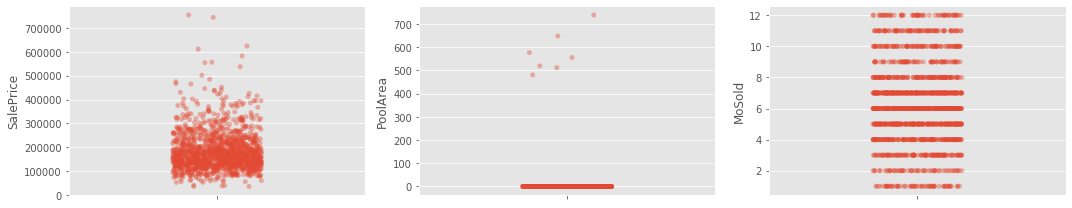

In [3]:
sample_df = house_df[['SalePrice', 'PoolArea','MoSold']]
plt.figure(figsize=(15, 3))

#function for plotting stripplots given a dataframe
def stripplot_these(df):
    for idx, name in enumerate(df.columns):
        n = idx + 1
        plt.subplot(1,3,n)
        sns.stripplot(x=name, data=df, jitter=0.15, orient= 'v', alpha=.4)
    plt.tight_layout()
    plt.show()

stripplot_these(sample_df)

With data that contains many different variables, plotting the variables to understand the distribution and characteristic would make spotting trends or patterns simpler

Regression models cannot work with ‘categorical’ type variables e.g. labels like ‘Hot’or ‘Cold’ instead of 33c or 15c.

The plot of our prediciton variable (Sale Price) looks to contain outliers (values which are outside the normal range of values) this could pose a problem to the model as regression models work by finding the ‘line of best fit’ through all the data, the model might be unfairly influence by these outliers.
Plotting the probability distribution of the Sale Price will help us validate this further.


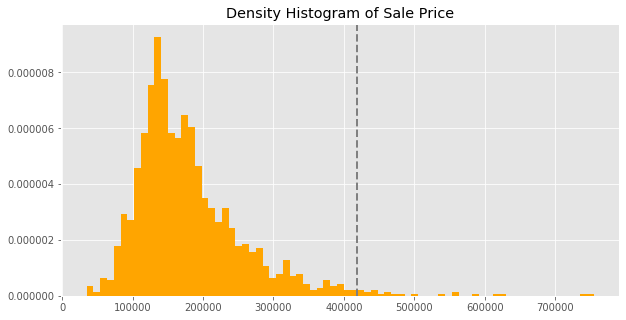

In [4]:
#plotting histogram of values with density values and outlier threshold 
mu = house_df.SalePrice.mean()
sd = house_df.SalePrice.std()
li = mu + 3 * sd
plt.figure(figsize=(10, 5))
plt.title('Density Histogram of Sale Price')
plt.hist(house_df.SalePrice, bins=75,density=True,color='orange')
plt.axvline(li, color='grey', linestyle='dashed', linewidth=2)
plt.show()

# Step 2 — Data Preperation

We won’t go into the programming efforts of transforming all the data here and instead list some of the ‘tricky’ questions which the data scientist would need to answer during this process,
-If product prices are missing, should we use an average value or fill it with the last known values?
-If gender labels are missing, should we fill with the most frequent gender or least frequent?
-If day of months data is missing, should we fill with the first, last, middle day of month?
-Are all variables in the correct data type? Are dates recorded as strings instead of datetime?

# Working Dataset

In [5]:

#list of column names to keep
col_names = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']

#creating new filtered dataframe
new_df =  house_df[col_names]

#print the new shape of the data,
print('The current number of rows and columns is:\n')
print(new_df.shape)
print('\nWe have reduce the number of variables from 81 to', new_df.shape[1],'\n')

#checking summary statistics and info of new dataframe
print(new_df.info())

The current number of rows and columns is:

(1460, 5)

We have reduce the number of variables from 81 to 5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
SalePrice      1460 non-null int64
OverallQual    1460 non-null int64
GrLivArea      1460 non-null int64
GarageCars     1460 non-null int64
GarageArea     1460 non-null int64
dtypes: int64(5)
memory usage: 57.1 KB
None


# Checking for Multicollinearity

Multicollinearity is when two variables are highly correlated, for example:
- Individuals height and weight are positively correlated
- Age of motor vehicles and the sales price is negatively correlated

Multicollinearity is a big problem in regression models, if present it causes regression models to be very sensitive and decreases the precision of the model.

We can check for evidence of Multicollinearity using a correlation heat map. Correlation values range between -1 and 1.

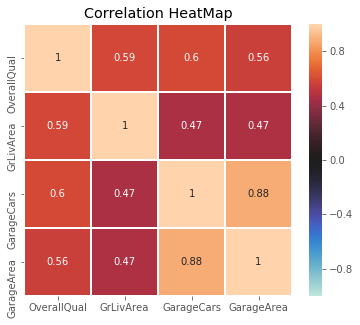

In [6]:
#filtering the dataframe to include just the IV's (features) and another with just the DV's (target)
features = new_df.loc[:,new_df.columns != 'SalePrice']
targets = new_df.loc[:,new_df.columns == 'SalePrice']

#creating pairwise correlation of columns using Pearson's R,
corr = features.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, annot=True, xticklabels=corr.columns, 
            yticklabels=corr.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

# Step 3 — Splitting the Data

Now we should be preparing the data for our regression model by splitting our data into two distinct sets of data —one for Training and another for Testing.

Why do we do this instead of just using the entire dataset?

In [7]:
#importing our function for splitting the data and an additional cross validation function,
from sklearn.model_selection import train_test_split, cross_val_score

#splitting our dataset randomly with the test data containing 10% of the data,
X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)

#view number of training and testing data
print('Our training prediction variable contains :',len(y_train) ,'rows')
print('Our training independent variable contains :',len(X_train) ,'rows')
print('Our testing prediction variable contains :',len(y_test) ,'rows')
print('Our testing independent variable contains :',len(X_test) ,'rows')

Our training prediction variable contains : 1314 rows
Our training independent variable contains : 1314 rows
Our testing prediction variable contains : 146 rows
Our testing independent variable contains : 146 rows


# Step 4 — Initializing the Model and Parameters

Whats important is choosing the right algorithm which suits the problem and then selecting the Model Parameters to initialize the model. This is harder than it seems.

In [8]:
#Allows us access to Scikit-learn linear regression model,
import sklearn.metrics
from sklearn.linear_model import LinearRegression

#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression()

# Step 5 — Training and Cross-Validation

Next, we will fit our training data to the model, which would run the regression algorithm towards the data and provides us with the coefficient values for each independent variable plus an intercept value.

In [9]:
#fitting the training data to the model,
reg_model.fit(X_train, y_train)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))

Intercept : -95130.3572705861 

      features   coeficients
0  OverallQual  26928.044974
1    GrLivArea     46.876019
2   GarageCars  11439.015444
3   GarageArea     42.100830


We can’t stop here yet. How do we know if the model is any good?

Below we compute a ‘score’ for the model (there are multiple metric for evaluating your model which we will see later), the metric seen here is the R-square value — we will analyze this metric soon.

In [10]:
#outputs the training and testing scores
print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

Training set score: 0.74


# K-Fold Cross Validation

The process of K-Fold Cross Validation:
- Choose a K value, for example, K = 5,
- now divide your data into 5 equal parts,
- take the first part and make that your testing set leaving the remaining 4 part for training,
- build the model and compute the accuracy score,
- repeat the process with the 2nd part as the testing set (instead of the first), and the 3rd part and so on until all 5 parts have been used for testing,
- compute the average score for all 5 iterations.

In [11]:
from sklearn.model_selection import cross_val_score
import math

cv_reg_model = LinearRegression()
cv_scores = cross_val_score(cv_reg_model, features, targets,cv=10, scoring='r2')

#outputs the scores
print('Cross Validation scores: {}'.format(cv_scores))
print("\nAverage 10-Fold CV Score: {}".format(np.mean(cv_scores)))

Cross Validation scores: [0.75029524 0.80036398 0.82433968 0.68085252 0.73961378 0.76077728
 0.72244919 0.74337524 0.60987683 0.77083604]

Average 10-Fold CV Score: 0.7402779778804515


# Step 6 — Testing

The first 5 prediction values are shown below along with a plot of all the Actual Values against the Predicted Values.

Sample predictions are:
 [139055.13566896 296056.74680143 125732.74509545 184999.98805346
 295874.20215181]


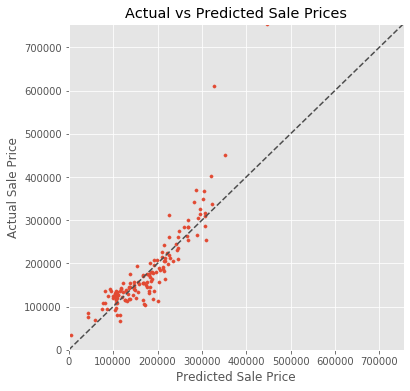

In [12]:
#prediction values using testing set
y_pred = reg_model.predict(X_test)

#printing sample of predictions
print('Sample predictions are:\n', y_pred[:5].flatten())

y_pred_a = pd.DataFrame(y_pred)
y_test_a = y_test.reset_index(drop=True, inplace=False)
pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

#output samples of our predicted values
plt.figure(figsize=(6, 6))
maxlimit = pred_act_df['SalePrice'].max()
plt.xlim(-1, maxlimit)
plt.ylim(-1, maxlimit)
plt.scatter(pred_act_df[0], pred_act_df['SalePrice'], s=10)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
plt.title('Actual vs Predicted Sale Prices')
plt.show()

In the graph above, the closer the points are to the diagonal line the better the accuracy of our predictions (it would mean our predicted values matches the actual values). Points above the line indicate a prediction value lower than the actual value and vice versa.

# Step 7 — Evaluation

For regression models which deal with predicting numerical values, evaluation metrics are:
- Root Mean Squared Error (RMSE),
- R-square and/or Adjusted R-squared,
- Residual Plots.

# Adjusted R-squared

In [13]:
#stats model library allows us to run OLS directly,
import statsmodels.api as sm 

#re-run OLS model as sm_model using training and testing dataset,
X_train_sm = sm.add_constant(X_train)
sm_train_model = sm.OLS(y_train, X_train_sm).fit()
print('Training set adj r2: {}'.format(sm_train_model.rsquared_adj))

#run CV again and loop through results applying adjusted r2 formula. Output the results
cv_scores_r2 = cross_val_score(cv_reg_model, features, targets,cv=10, scoring='r2')
cv_scores_adj = []
n = len(features)
k = len(features.columns)
for r in cv_scores_r2:
    adj_r2 = 1-(((1-r)*(n-1))/(n-k-1))
    cv_scores_adj.append(adj_r2)
print('Average 10-Fold CV adj r2: {}'.format(np.mean(cv_scores_adj)))

C:\Users\Mohammed Shihab\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Training set adj r2: 0.7372266170220936
Average 10-Fold CV adj r2: 0.7395639654485078


# Root Mean Squared Error (RMSE)

In [14]:
#for calculating MSE
from sklearn.metrics import mean_squared_error

y_pred_test = reg_model.predict(X_test)
y_pred_train = reg_model.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

Root Mean Squared Error of Training Set: 39619.60478407112
Root Mean Squared Error of Testing Set: 46705.23557800472


# P-value and Significants of Variables

In [15]:
#lets us use the stats model ols model
import statsmodels.api as sm 

#training the OLS algorithm and outputting the summary statistics
X_train_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_train_sm).fit()
print(sm_model.summary())
print(sm_model.rsquared_adj)

C:\Users\Mohammed Shihab\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     921.9
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        05:33:03   Log-Likelihood:                -15776.
No. Observations:                1314   AIC:                         3.156e+04
Df Residuals:                    1309   BIC:                         3.159e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.513e+04   5031.491    -18.907      

# Residual Plot

Viewing a plot of the residual errors is an important step in evaluating regression models. This is a graph which plots each positive and negative residual error which are the outcome of actual values minus the predicted values.

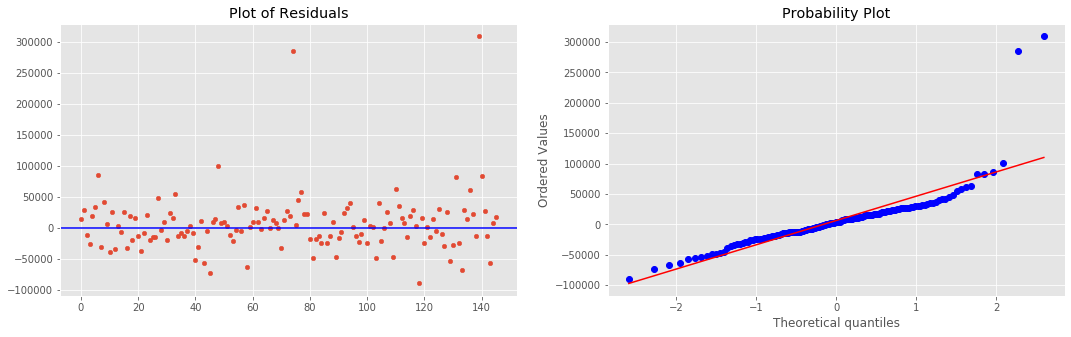

In [16]:
#calculate the residuals
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
residuals = y_test.SalePrice - y_pred[0]

#plotting Residual and Probabililty graph
plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
plt.axhline(0, color="blue")
plt.title('Plot of Residuals')
plt.scatter(residuals.index,residuals, s=20)

plt.subplot(1,2,2)
plt.title('Probability Plot')
stats.probplot(residuals, dist='norm',plot=plt)
plt.show()